In [1]:
import os, sys, glob, datetime, time, pytz

from keras import __version__

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
# Defining variables
EPOCHS        = 100
BAT_SIZE      = 20
DATA_SET_DIR  = '/home/jupyter/clothing-dataset/data/' # clothing dataset 10.
MODEL_NAME    = 'VGG16'

WIDTH, HEIGHT = 128, 128
FC_SIZE       = 256
DROPOUT       = 0.5

TRAIN_DIR        = DATA_SET_DIR + 'train'
TEST_DIR         = DATA_SET_DIR + 'test'
nb_classes       = len(glob.glob(TRAIN_DIR + "/*"))

timezone = pytz.timezone("Asia/Jakarta")

now = timezone.localize(datetime.datetime.now())

## 1. Image augmentation untuk data training dan validation

Di bawah ini adalah langkah pertama yang dilakukan.

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Training Sample


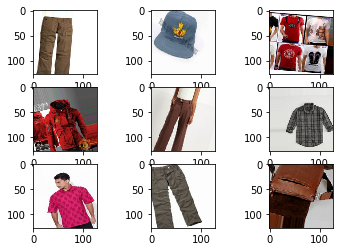

Validation Sample


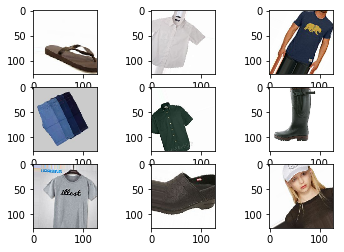

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen =  ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(WIDTH, HEIGHT),
    batch_size=BAT_SIZE,
    subset='validation'
)

print('Training Sample')
x,y = train_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

print('Validation Sample')
x,y = validation_generator.next()
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    image = x[i]
    plt.imshow(image)

plt.show()

## 2. Instansiasi arsitektur model dari keras, dan menghilangkan top layer-nya

Berikutnya adalah instansiasi arsitektur model aslinya. Model aslinya sendiri sudah tersedia secara built-in di dalam keras. Maka dari itu proses instansiasi-nya menjadi sangat sederhana.

Berikut adalah proses instansiasi tersebut

In [4]:
from keras.applications.vgg16 import VGG16

from keras.utils.vis_utils import plot_model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

print('Model tanpa top layer terdiri dari %d layer' % len(base_model.layers))

W0717 10:00:44.382740 140233158727104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 10:00:44.419162 140233158727104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 10:00:44.424213 140233158727104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0717 10:00:44.455354 140233158727104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0717 10:00:44.833314 140233158727104 deprecation_wrapp

Model tanpa top layer terdiri dari 19 layer


## 3. Simpan bottleneck features

Pada langkah ini, bottleneck features dari model asli yang sudah di training ke imagenet akan disimpan.

Berikut adalah langkah tersebut

In [5]:
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.models import Sequential
from keras.utils.np_utils import to_categorical

train_file_is_exist = os.path.isfile(MODEL_NAME + '_train.npy')
if train_file_is_exist == False:
    print('File ' + MODEL_NAME + '_train.npy tidak ditemukan. Menyimpan...')
    bottleneck_features_train = base_model.predict_generator(train_generator, train_generator.samples // BAT_SIZE)
    np.save(open(MODEL_NAME + '_train.npy', 'w'),bottleneck_features_train)
    print('Tersimpan')
else:
    print('File ' + MODEL_NAME + '_train.npy ditemukan')

validation_file_is_exist = os.path.isfile(MODEL_NAME + '_validation.npy')
if validation_file_is_exist == False:
    print('File ' + MODEL_NAME + '_validation.npy tidak ditemukan. Menyimpan...')
    bottleneck_features_validation = base_model.predict_generator(validation_generator, validation_generator.samples // BAT_SIZE)
    np.save(open(MODEL_NAME + '_validation.npy', 'w'),bottleneck_features_validation)
    print('Tersimpan')
else:
    print('File ' + MODEL_NAME + '_validation.npy ditemukan')

File VGG16_train.npy ditemukan
File VGG16_validation.npy ditemukan


## 4. Load bottleneck features yang sudah disimpan sebelumnya

Langkah ini dilakukan untuk memuat bottleneck features dan menjadikannya numpy array.

Berikut adalah langkahnya.

In [6]:
num_classes = len(train_generator.class_indices)

# train_data = np.load(open(MODEL_NAME + '_train.npy'))
with open(MODEL_NAME + '_train.npy') as train:
    train_data = np.load(train)
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

# validation_data = np.load(open(MODEL_NAME + '_validation.npy'))
with open(MODEL_NAME + '_validation.npy') as validation:
    validation_data = np.load(validation)
validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

## 5. Buat layer baru untuk klasifikasi

Layer baru ini akan di training menggunakan weight dari bottleneck features

In [7]:
from keras.optimizers import SGD

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_data.shape[1:]))
model.add(Dense(FC_SIZE, activation='relu'))
model.add(Dropout(DROPOUT))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),loss='categorical_crossentropy', metrics=['accuracy'])

W0717 10:00:46.127902 140233158727104 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0717 10:00:46.173057 140233158727104 deprecation_wrapper.py:119] From /usr/local/lib/python2.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## 5. Training model

Langkah berikutnya adalah training model yang telah di set-up pada langkah sebelumnya.

Berikut adalah langkahnya

In [8]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
print(validation_data.shape)
print(validation_labels.shape)
sys.exit()
training_start_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
start = time.time()
history = model.fit(train_data, train_labels,
          epochs=EPOCHS,
          batch_size=BAT_SIZE,
          validation_data=(validation_data, validation_labels))
end = time.time()
training_end_datetime = timezone.localize(datetime.datetime.now()).strftime("%Y-%m-%d %H:%M:%S")
print('Training from %s to %s taking %d seconds.' % (training_start_datetime, training_end_datetime, (end - start)))

(2000, 4, 4, 512)
(2000, 10)


SystemExit: 

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Langkah Tambahan: Simpan model

In [ ]:
model.save(MODEL_NAME + 'V1.model')
print('Model ' + MODEL_NAME + 'V1.model. Tersimpan.')

## Langkah tambahan: Tampilkan accuracy, loss, confusion matrix serta classification report

Langkah ini dilakukan untuk menampilkan kurva accuracy dan loss dari training yang telah dilakukan. Serta confusion matrix untuk testing. Selain itu detail laporan terkait precision, f-score dan recall juga ditampilkan di sini.

Berikut adalah langkahnya

In [ ]:
import itertools
from sklearn.utils.multiclass import unique_labels

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r.', label='training')
plt.plot(epochs, val_acc, 'r', label='validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

# Loss
plt.plot(epochs, loss, 'r.', label='training')
plt.plot(epochs, val_loss, 'r-', label='validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()